In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import xgboost as xgb
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV

In [2]:
def root_mean_log_squared_error(y_test,predicted):
    return np.sqrt(np.sum((np.log(1+y_test)-np.log(1+predicted))**2)/len(predicted))

In [3]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')
price_doc = pd.read_csv('train.csv', usecols=['price_doc'])
target = price_doc['price_doc']
answer = pd.read_csv('test.csv', usecols=['id'])

In [4]:
ylog_target = np.log1p(target)

# Важные параметры

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_train, ylog_target, test_size=0.2, random_state=228)

In [6]:
model = xgb.XGBRegressor(objective='reg:linear')

In [7]:
model.fit(df_train, ylog_target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [8]:
x = model.get_booster().get_score(importance_type='weight')

In [9]:
features_imp = []
for feature in x.keys():
    if (x[feature] > 3) :
        features_imp .append(feature)

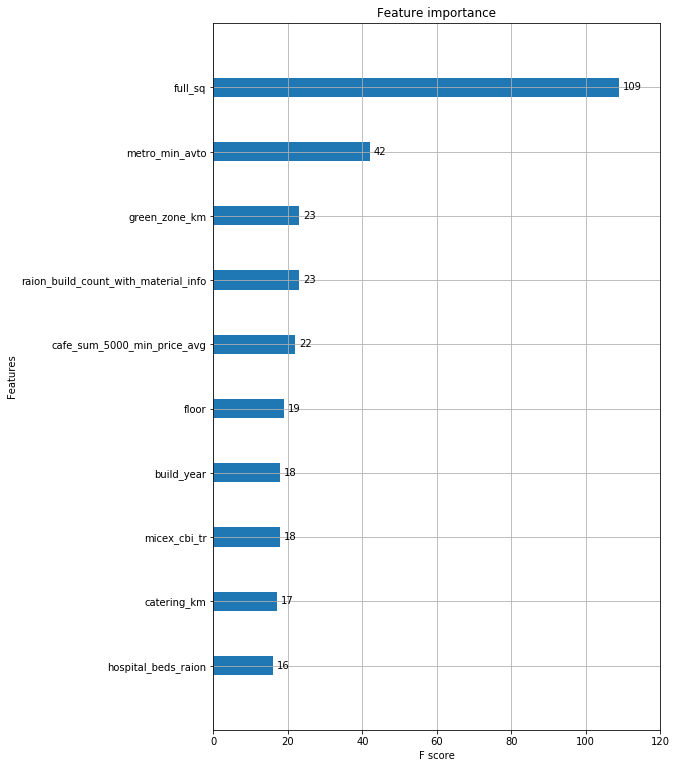

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=10, height=0.3, ax = ax)


# Модель

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_train, ylog_target, test_size=0.2, random_state=228)

In [12]:
df_train = pd.read_csv('df_train.csv', usecols = features_imp)
df_test = pd.read_csv('df_test.csv', usecols = features_imp)

In [13]:
XGBmodel = xgb.XGBRegressor(objective='reg:linear')

In [14]:
#parameters = [{
  #  'max_depth': [4, 5, 6], #max_depth=4
  #  'learning_rate': [0.01, 0.3],  #learning_rate=0.2
  #  'n_estimators':  [100, 110, 120], #n_estimators=110
  #  'colsample_bytree': [0.7, 0.8], #colsample_bytree=0.8
  #  }]

parameters = [{
    'max_depth': [4],
    'learning_rate': [0.2],  
    'n_estimators':  [110], 
    'colsample_bytree': [0.8] 
    }]

In [15]:
grid_xgr = GridSearchCV(XGBmodel, parameters, cv=10, n_jobs=4, verbose=1, scoring='neg_mean_squared_log_error') 

In [16]:
grid_xgr.fit(df_train, ylog_target)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   34.5s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'max_depth': [4], 'learning_rate': [0.2], 'n_estimators': [110], 'colsample_bytree': [0.8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_log_error', verbose=1)

In [17]:
print(grid_xgr.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=110,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [18]:
predictions = grid_xgr.best_estimator_.predict(df_test)

In [19]:
predictions = (np.exp(predictions) - 1)

In [20]:
predictions

array([5372762. , 7841313.5, 5293356. , ..., 4722776. , 5468082. ,
       7842614.5], dtype=float32)

In [21]:
#root_mean_log_squared_error(y_test, predictions) #0.2617

In [22]:
answer['price_doc'] = predictions

In [23]:
answer.to_csv('out.csv', encoding='utf-8', index=False)